In [1]:
import jax
import numpy as np
import pandas as pd
import random

class MaskSVDSimulator(object):
    def __init__(self, 
                 study_names: list,     # list of study names
                 sample_nums: list,     # list of numbers, the sample number of each studies
                 feature_dim: int,      # number of species
                 latent_dim: int,       # number of latent Sigma matrix
                 noise_ratio: float,    # noise ratio, ratio of E and Sigma
                 ):  
        
        self.study_names = study_names
        self.sample_nums = sample_nums
        self.feature_dim = feature_dim
        self.latent_dim = latent_dim
        self.noise_ratio = noise_ratio

        self.num_of_studies = len(study_names)
        self.Xs = list()
        self.Us = list()
        self.Sigmas = list()
        self.V = None
        self.Cs = list()
        self.X = None

    
    def _gen_random_ortho(self, n: int, k:int):
        random_matrix = np.random.rand(n, n)
        q, _ = np.linalg.qr(random_matrix)
        return q[:, :k]
    
    def _assign_features(self, avg_prop=0.4): # assign the considered features (species) for each study
        self.Cs = list()
        for i in range(self.num_of_studies):
            prop = np.random.uniform(0.5, 1.5) * avg_prop
            prop = np.min([prop, 1.0])
            study_feature_dim = round(self.feature_dim*prop)
            
            C_list = [1]*study_feature_dim + [0]*(self.feature_dim-study_feature_dim)
            random.shuffle(C_list)
            self.Cs.append(np.diag(C_list))

    def _clear_all(self):
        self.Xs = list()
        self.Us = list()
        self.Sigmas = list()
        self.V = None
        self.Cs = list()
    
    def _concat_Xs(self):
        assert len(self.Xs) == self.num_of_studies

        repeated_study_names = [self.study_names[i] for i in range(self.num_of_studies) for _ in range(self.sample_nums[i])]
        feature_names = [f'species_{i}' for i in range(self.feature_dim)]
        X = np.vstack(self.Xs)

        self.X = pd.DataFrame({'study_names': repeated_study_names, **dict(zip(feature_names, X.T))})
        type_dict = {'study_names': str}
        for col_names in self.X.columns[1:]:
            type_dict[col_names] = float
        self.X = self.X.astype(type_dict)
        return self.X

    def simulate(self, magnitude = 10000, new_V=False): # new_V means we remove the current V matrix and generate a new one
        self._assign_features()
        if new_V or self.V is None: 
            self.V = self._gen_random_ortho(self.feature_dim, self.latent_dim)
        for i in range(self.num_of_studies):            
            # generate Sigma by an inverse gamma distribution
            alpha = np.random.uniform(2.0, 4.0)
            beta = np.random.uniform(0.5, 1.5)
            sigma_list = 1/np.random.gamma(alpha, scale=beta, size=self.latent_dim)
            sigma_list = np.sort(sigma_list)[::-1]

            Sigma = np.diag(magnitude * sigma_list)
            self.Sigmas.append(Sigma)

            # generate U
            U = self._gen_random_ortho(self.sample_nums[i], self.latent_dim)
            self.Us.append(U)

            # generate noise 
            noise_level = np.max(sigma_list) * self.noise_ratio
            E = np.random.normal(0, noise_level, size=(self.sample_nums[i], self.feature_dim))

            X = U@Sigma@self.V.T@self.Cs[i]
            self.Xs.append(X)

        assert self.X is None
        self._concat_Xs()
        return self.X

In [89]:
study_names = ['A', 'B', 'C']
sample_nums = [100, 150, 200, 250, 300]
feature_dim = 200
latent_dim = 20
noise_ratio = 0.1
magnitude = 10000

simulator = MaskSVDSimulator(study_names, sample_nums, feature_dim, latent_dim, noise_ratio)
X = simulator.simulate(magnitude=magnitude)

In [90]:
X

,study_names,species_0,species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,...,species_490,species_491,species_492,species_493,species_494,species_495,species_496,species_497,species_498,species_499
0,A,0.0,0.139318,0.0,0.109443,0.0,0.0,0.110258,0.0,0.202239,...,0.103365,0.313747,0.157628,0.110025,0.0,0.236788,0.000000,-0.072696,0.032299,0.036061
1,A,0.0,0.174102,0.0,0.112131,0.0,0.0,0.237219,0.0,0.252329,...,0.191057,0.495607,0.331383,0.071089,0.0,0.348465,0.000000,0.032674,0.176709,-0.077696
2,A,0.0,0.161287,0.0,-0.031869,0.0,0.0,0.385931,0.0,0.422557,...,0.458452,0.356543,0.527347,-0.052909,0.0,0.354677,0.000000,0.166784,0.288193,0.078807
3,A,0.0,0.048877,0.0,0.210383,0.0,0.0,0.021315,0.0,-0.009801,...,-0.051141,0.181094,-0.014097,0.146809,0.0,0.039727,0.000000,0.046013,-0.031711,0.121279
4,A,0.0,0.032815,0.0,-0.009703,0.0,0.0,-0.082518,0.0,0.036107,...,0.145336,-0.060684,0.037696,-0.026384,0.0,0.023979,0.000000,0.038808,0.021669,0.100378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,C,0.0,0.048792,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.079330,0.000000,0.000000,0.039500,0.0,0.000000,0.044590,0.044271,0.000000,0.030522
446,C,0.0,0.031230,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.055895,0.000000,0.000000,-0.005060,0.0,0.000000,0.081105,-0.030357,0.000000,-0.014060
447,C,0.0,0.022942,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.064086,0.000000,0.000000,-0.031373,0.0,0.000000,0.059863,0.055000,0.000000,-0.003947
448,C,0.0,0.014823,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.025423,0.000000,0.000000,-0.013131,0.0,0.000000,0.049663,-0.012831,0.000000,0.033530


In [91]:
X.iloc[:, 1:].values

array([[ 0.        ,  0.13931803,  0.        , ..., -0.07269558,
         0.0322991 ,  0.03606102],
       [ 0.        ,  0.17410157,  0.        , ...,  0.03267422,
         0.17670896, -0.07769609],
       [ 0.        ,  0.1612866 ,  0.        , ...,  0.16678425,
         0.28819289,  0.07880731],
       ...,
       [ 0.        ,  0.02294176,  0.        , ...,  0.05499991,
         0.        , -0.00394678],
       [ 0.        ,  0.01482278,  0.        , ..., -0.01283113,
         0.        ,  0.03353032],
       [ 0.        ,  0.02024778,  0.        , ...,  0.0757565 ,
         0.        ,  0.04942535]])

In [92]:
X_val = np.exp(10*X.iloc[:, 1:].values)
X_val

array([[ 1.        ,  4.02763874,  1.        , ...,  0.48337823,
         1.3812529 ,  1.43420432],
       [ 1.        ,  5.70313327,  1.        , ...,  1.38644395,
         5.85379174,  0.45980128],
       [ 1.        ,  5.01716989,  1.        , ...,  5.30071892,
        17.84866746,  2.19915471],
       ...,
       [ 1.        ,  1.25786725,  1.        , ...,  1.73325148,
         1.        ,  0.96130087],
       [ 1.        ,  1.15977706,  1.        , ...,  0.87957955,
         1.        ,  1.39836435],
       [ 1.        ,  1.2244329 ,  1.        , ...,  2.13307589,
         1.        ,  1.63927411]])

In [74]:
simulator.Sigmas

[array([[1.51861073, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.31556612, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.15441671, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.99952812, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.96078818,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.8700994 , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.76326974, 0.        , 0.        , 0.        ],
        [0.        , 0.    

<AxesSubplot:>

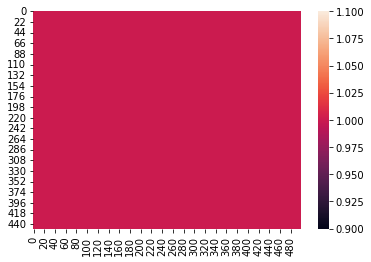

In [95]:
import seaborn as sns

sns.heatmap(X_val != 0)